In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
y = covertype.data.targets

df_combined = X.copy()
df_combined['Cover_Type'] = y['Cover_Type']

# metadata
print(covertype.metadata)

# variable information
print(covertype.variables)

# Check in week 4

We will make a classification model to predict if a certain observation from cartographic variables comes from wilderness area type Rawah (area 1) or Comanche Peak (area 3).

By subsetting the dataset to only include rows with wilderness area 1 and 3, We will use Wilderness_Area1 as the binary response variable. If Wilderness_Area1 is 1, the observation is from Rawah. If Wilderness_Area1 is 0, the observation is from Comanche Peak.

In [ ]:
wilderness_area = X[["Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4"]]
wilderness_area.sum()

,0
Wilderness_Area1,260796
Wilderness_Area2,29884
Wilderness_Area3,253364
Wilderness_Area4,36968


In [ ]:
mask = (X["Wilderness_Area1"] == 1) | (X["Wilderness_Area3"] == 1)
subset = X[mask]
subset = subset[["Elevation", "Aspect", "Slope",
                  "Horizontal_Distance_To_Hydrology",	"Vertical_Distance_To_Hydrology",
                  "Horizontal_Distance_To_Roadways",	"Hillshade_9am", "Hillshade_Noon",
                  "Hillshade_3pm",	"Horizontal_Distance_To_Fire_Points",
                  "Wilderness_Area1"]]
display(subset.head())

print(subset.shape)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1
0,2596,51,3,258,0,510,221,232,148,6279,1
1,2590,56,2,212,-6,390,220,235,151,6225,1
2,2804,139,9,268,65,3180,234,238,135,6121,1
3,2785,155,18,242,118,3090,238,238,122,6211,1
4,2595,45,2,153,-1,391,220,234,150,6172,1


(514160, 11)


In [ ]:
# correlation to pick predictors
subset.corr()["Wilderness_Area1"].sort_values()

,Wilderness_Area1
Slope,-0.210529
Vertical_Distance_To_Hydrology,-0.184432
Aspect,-0.122357
Horizontal_Distance_To_Hydrology,-0.121624
Hillshade_3pm,-0.119540
Hillshade_Noon,-0.012269
Elevation,0.044681
Hillshade_9am,0.181227
Horizontal_Distance_To_Fire_Points,0.368856
Horizontal_Distance_To_Roadways,0.387442


The variables with the highest magnitude correlation with Wilderness_Area1 are Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Fire_Points, and Horizontal_Distance_To_Roadways. We will use these as predictors.

In [ ]:
# prepare logistic regression predictors and response
X_log = subset[["Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Fire_Points", "Horizontal_Distance_To_Roadways"]]
y_log = subset[["Wilderness_Area1"]]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size = 0.2)

In [ ]:
# model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7211082153415279


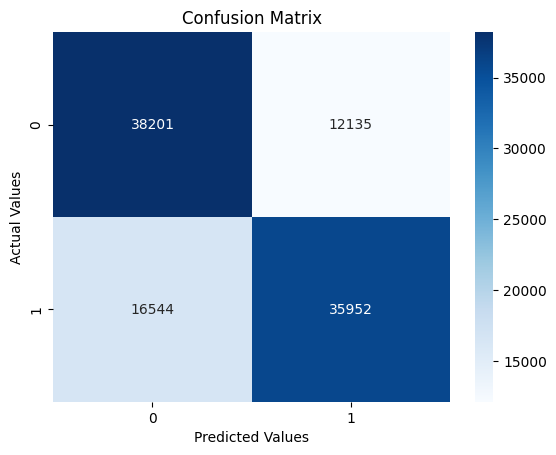

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

The Prediction Accuracy for our model is 0.7218472848918625.

The Prediction Error is 0.27815271510813755.

The true positive rate (recall) is 35774/(35774+16413) = 0.685496387989346.

The Precision of the model is 35774/(35774 + 12190) = 0.7458510549578851.


A confusion matrix summarizes the performance of a classification model on a test set. From the above, we can see that the model correctly predicted the true positive class "wilderness area1 = 1" 35774 times and correctly guessed the true negative class "wilderness area1 = 0" 38455 times and false negative 16413 and false positive 12190. The above percentages are the accuracies.


ROC curve:

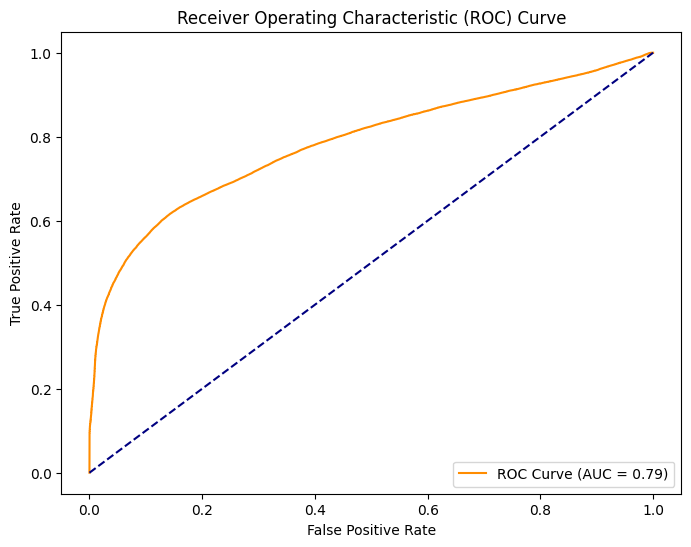

In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The AUC value for this model is 0.79.

Our ROC curve is good because it curves steeply upwards and then to the right and the AUC which is 0.79 explains the performance of our classification model. As it is closer to 1 than it is 5, we can say that our model can properly distinguish between positive and negative classes.

5-fold cross-validation:

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate

# 5-fold cross-validation on the test set
cv_results = cross_validate(model, X_test, y_test, cv=5,
                            scoring=['accuracy', 'roc_auc'])

print("Cross-validation results (Accuracy):", cv_results['test_accuracy'])
print("Cross-validation results (AUC):", cv_results['test_roc_auc'])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Cross-validation results (Accuracy): [0.71634171 0.72120387 0.71856462 0.7197316  0.72396188]
Cross-validation results (AUC): [0.78537931 0.78716959 0.78485341 0.78529311 0.78890844]


In [ ]:
print(cv_results['test_accuracy'])
print(cv_results['test_roc_auc'])

[0.71634171 0.72120387 0.71856462 0.7197316  0.72396188]
[0.78537931 0.78716959 0.78485341 0.78529311 0.78890844]


On the top is the test accuracy which are all relatively close to each other with a range of around 0.01 which is consistent which means our model is not dependent on our training or testing set and we are not overfitting.

The bottom is the AUC which is also consistent with a range of 0.007 and close to 1 which indicates that our model is able to distinguish between the two wilderness areas properly.

In [ ]:
subset[subset.Wilderness_Area1 == 1].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1
count,260796.000000,260796.000000,260796.000000,260796.000000,260796.000000,260796.000000,260796.000000,260796.000000,260796.000000,260796.000000,260796.0
mean,3000.267286,138.280273,12.157292,246.553333,34.745744,3134.408055,218.117199,223.948017,137.644385,2538.703600,1.0
std,200.271001,106.232453,6.708537,188.301562,47.114353,1743.157038,22.018575,16.986753,33.939194,1538.413717,0.0
min,2473.000000,0.000000,0.000000,0.000000,-159.000000,0.000000,56.000000,74.000000,0.000000,0.000000,1.0
25%,2870.000000,56.000000,7.000000,95.000000,4.000000,1572.000000,208.000000,215.000000,118.000000,1426.000000,1.0
50%,3002.000000,103.000000,11.000000,210.000000,22.000000,3155.000000,223.000000,226.000000,138.000000,2230.000000,1.0
75%,3151.000000,210.000000,16.000000,360.000000,51.000000,4589.000000,233.000000,235.000000,158.000000,3260.000000,1.0
max,3686.000000,360.000000,61.000000,1124.000000,431.000000,7117.000000,254.000000,254.000000,251.000000,7173.000000,1.0


In [ ]:
subset[subset.Wilderness_Area1 == 0].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1
count,253364.000000,253364.000000,253364.000000,253364.000000,253364.000000,253364.000000,253364.000000,253364.000000,253364.000000,253364.000000,253364.0
mean,2980.554471,165.189549,15.173786,298.923272,56.153171,1937.118438,209.084606,224.412320,146.478482,1562.401351,0.0
std,239.272648,112.023982,7.293288,236.972143,65.699674,994.475116,26.825679,20.718219,39.305238,796.189731,0.0
min,2270.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,2820.000000,59.000000,10.000000,120.000000,10.000000,1180.000000,194.000000,212.000000,121.000000,942.000000,0.0
50%,2997.000000,158.000000,14.000000,242.000000,38.000000,1831.000000,213.000000,227.000000,147.000000,1475.000000,0.0
75%,3160.000000,266.000000,19.000000,426.000000,83.000000,2610.000000,229.000000,241.000000,175.000000,2123.000000,0.0
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,5463.000000,254.000000,254.000000,254.000000,4589.000000,0.0


We stayed with the default threshold of 0.5 in a logistic regression model, since the number of observations belonging to Wilderness_Area_1 is approximately similar to Wilderness_Area_3 and also sets an equal decision boundary where both Wilderness Areas are equally probable. If we were to adjust the threshold solely due to Wilderness_Area_1 having a slightly higher frequency in this dataset, we believe this would imply that Area 1 should be predicted more often when this may not be representative of the true population-level probabilities.